# THUCNews

最近试图把机器学习的东西捡起来。于是随便找了个数据集练习了一下。

* 数据集： https://www.kaggle.com/datasets/trumanjagan/thucnews
  * 如果遇到乱码问题，记得带上编码参数：`unzip -O utf-8 -q THUCNews.zip`
* 练习赛：中文新闻文本标题分类 https://aistudio.baidu.com/aistudio/competition/detail/10/0/introduction

In [1]:
from experiment import (
    ExperimentParameters,
    load_data,
    setup_datasets,
    NewsTitleClassifierBaseline,
    NewsTitleClassifierContrastive,
    Tester,
    train
)

/home/leo/blog/machine_learning/THUCNews/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
PARAMS = ExperimentParameters()
load_data(PARAMS)
setup_datasets(PARAMS)
PARAMS.MODEL = NewsTitleClassifierBaseline(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    PARAMS.tag_list,
).to(PARAMS.DEVICE)
PARAMS.tester = Tester(PARAMS, PARAMS.quick_test_dataset)

loading data...
dict_keys(['财经', '股票', '科技', '社会', '游戏', '星座', '时政', '时尚', '教育', '房产', '彩票', '家居', '娱乐', '体育'])
splitting datasets...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 数据挖掘

首先我们数据挖掘一下，看看数据集标签的比例。

In [12]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

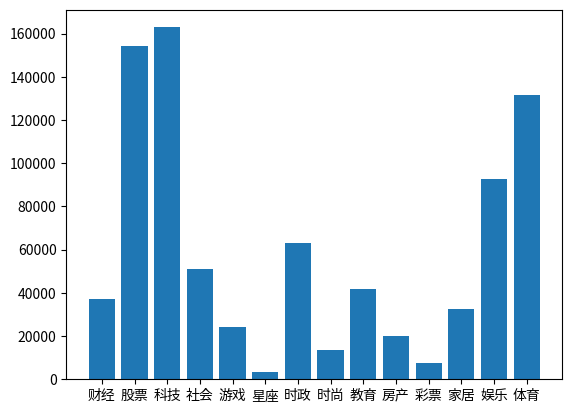

In [9]:
ys = [y for y, x in PARAMS.category_and_titles]
catag_count = [ys.count(tag) for tag in PARAMS.tag_list]

fig, ax = plt.subplots()
ax.bar(PARAMS.tag_list, catag_count)

plt.show()

## 普通模型

In [ ]:
PARAMS.MODEL = NewsTitleClassifierBaseline(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    PARAMS.tag_list,
).to(PARAMS.DEVICE)

train_accuracy_record, test_accuracy_record = train(PARAMS)

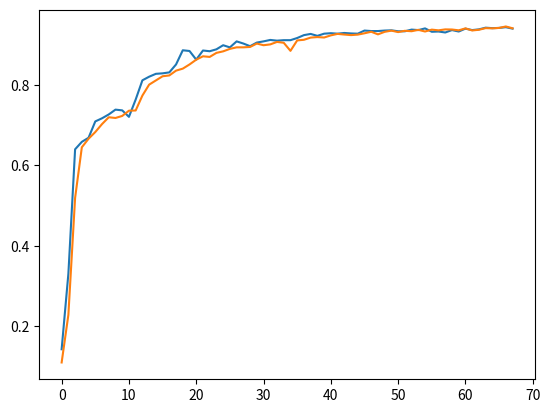

In [32]:
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.show()

## 对比学习
试试CLIP https://github.com/openai/CLIP

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive, test_accuracy_record_contrastive = train(PARAMS)

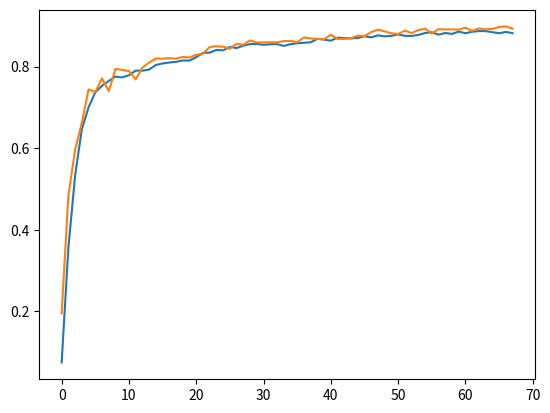

In [8]:
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, train_accuracy_record_contrastive, test_accuracy_record_contrastive)
plt.show()

### 用Prompt做对比学习

In [ ]:
prompts = [f"这是一篇{tag}新闻" for tag in PARAMS.tag_list]

PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=prompts,
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive_prompt, test_accuracy_record_contrastive_prompt = train(PARAMS)

### 去掉softmax

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
    softmax=False
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive_no_softmax, test_accuracy_record_contrastive_no_softmax = train(PARAMS)

### 对称loss

才看到论文里面有一个：

```python
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

然后[代码](https://github.com/openai/CLIP/blob/main/clip/model.py)里面是这样的：

```python
# cosine similarity as logits
logit_scale = self.logit_scale.exp()
logits_per_image = logit_scale * image_features @ text_features.t()
logits_per_text = logits_per_image.t()

# shape = [global_batch_size, global_batch_size]
return logits_per_image, logits_per_text
```

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
    softmax=True
).to(PARAMS.DEVICE)

records_symmetric_loss = train(PARAMS, symmetric_loss=True)

# 分析对比

In [9]:
import pickle
with open("./records.pickle", "rb") as file:
    records = pickle.load(file)

In [18]:
import pickle

with open("./records.pickle", "wb") as file:
    records.update({"contrastive_with_softmax_with_symmetric": records_symmetric_loss})
    pickle.dump(records, file)


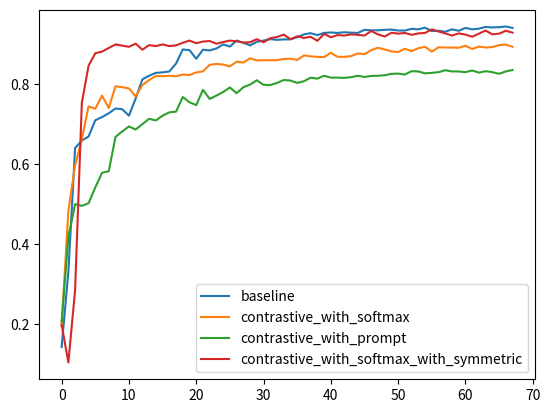

In [20]:
batch_num = [i for i in range(len(records_symmetric_loss[1]))]
plt.plot(batch_num, records["baseline"][1], label="baseline")
plt.plot(batch_num, records["contrastive_with_softmax"][1], label="contrastive_with_softmax")
plt.plot(batch_num, records["contrastive_with_prompt"][1], label="contrastive_with_prompt")
plt.plot(batch_num, records["contrastive_with_softmax_with_symmetric"][1], label="contrastive_with_softmax_with_symmetric")
plt.legend()
plt.show()